## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [79]:
from IPython.display import clear_output
import string
import os
import numpy as np
import matplotlib.pyplot as plt
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.autograd import Variable

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [107]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [108]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text= "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [109]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r', encoding = "utf_8_sig" ) as iofile:
    # text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]
# text= "".join(text).lower()

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [110]:
out = text
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [114]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [115]:
def to_matrix(texts, max_len=None, pad=token_to_idx[' '], dtype='int32', 
              batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, texts))
    texts_ix = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        line_ix = [token_to_idx[c] for c in texts[i]]
        texts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        texts_ix = np.transpose(texts_ix)

    return texts_ix

In [124]:
class CharRNNCeil(nn.Module):
    
    def __init__(self, num_tokens=num_tokens, embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_state=None):
        x_embed = self.embedding(x.view(1, -1))
        out, h_next = self.rnn(x_embed.view(1, 1, -1), h_state)
        logits = self.rnn_to_logits(out.view(1, -1))
        return logits, h_next
    
    def initial_state(self):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, 1, self.num_units))


def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state()
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        logp_next, hid_state  = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [125]:
def get_chunk(chunk_size=300):
    start_index = np.random.randint(0, len(text) - chunk_size)
    end_index = start_index + chunk_size + 1
    return text[start_index:end_index]

In [128]:
def train(model, opt, criterion, chunk_size=200, epochs=2000, num_tokens=num_tokens):
    history = []
    for i in range(epochs):
        batch_ix = to_matrix([get_chunk(chunk_size)])
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(model, batch_ix)
        # compute loss
        
        loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                         batch_ix[:, 1:].contiguous().view(-1))
        
        
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        history.append(loss.data.numpy())
        if (i+1)%100==0:
            clear_output(True)
            plt.figure(figsize = (14, 6))
            plt.plot(history,label='loss')
            plt.grid()
            plt.legend()
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

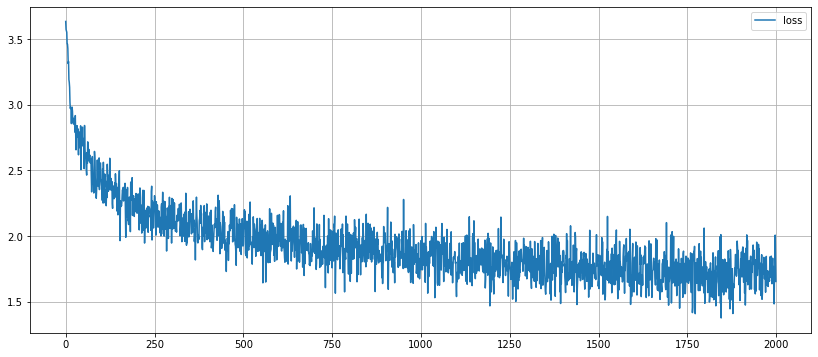

In [129]:
# Your plot code here
char_rnn = CharRNNModel()
opt = torch.optim.Adam(char_rnn.parameters())
criterion = nn.CrossEntropyLoss()
train(char_rnn, opt, criterion)

In [130]:
MAX_LENGTH = 500

In [131]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[-1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        p_next = p_next.flatten()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([next_ix], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=0)
        # print(x_sequence)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()])

# examples of generated text.
print(generate_sample(char_rnn, seed_phrase="the", max_length=500, temperature=0.8))

the lies, have nother dould stand hen yind whe mall of to mund that thear as it the whold woldsticht whilful men or the botrse,
  of momath the wortn noth then thouge that with detion the worth well.
  thy wroups timlly stcant of delight be pace that sumpard and fren whine so prabest hearto, have of your delel.
  and love
  thought, ang dove such to then shased and foon, thess will shall with when, or stor whith her gatiegh the sell--o do my ruming besidd that stall incelforn.
    by bearsh lest


In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [132]:
# Your beautiful code here
class CharLSTMModel(nn.Module):
    
    def __init__(self, num_tokens=num_tokens, embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    
    def forward(self, x, h_state):
        x_emb = self.embedding(x.view(1, -1))
        h_seq, h_next = self.lstm(x_emb.view(1, 1, -1), h_state)
        logits = self.hid_to_logits(h_seq.view(1, -1))
        return logits, h_next
    
    
    def initial_state(self):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(1, 1, self.num_units)), Variable(torch.zeros(1, 1, self.num_units)))

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

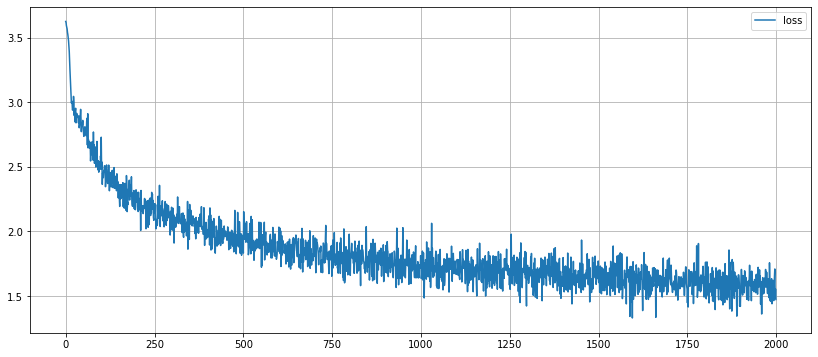

In [133]:
char_lstm = CharLSTMModel()
opt = torch.optim.Adam(char_lstm.parameters())
criterion = nn.CrossEntropyLoss()
train(char_lstm, opt, criterion, chunk_size=500, epochs=2000)

In [136]:
# Text generation with different temperature values here

# examples of generated text.
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temperatures:
    print()
    print('Temperature:', t)
    print(generate_sample(char_lstm, seed_phrase=" ", max_length=500, temperature=t))


Temperature: 0.1
 the see thee thee,
  and the see the see the see the see the see thee,
  and the shall the see the see the see the see,
    the the see the self the see the see thee,
  and the see the see the see the see the see,
    the see the see the see the see the see thee,
  and the see the see the see the see the see thee:
    then the seet the see the see the see thee,
  and the see the see the see the see the see,
    the see the see the see the shall the see thee,
  and the see the see the see the se

Temperature: 0.2
 the see thee,
  and the see the the the see the see the see thee:
    then the see the see sunder and the see thee,
  and the seet the beauty the see the grease,
  and the seet the love the shall should the see,
    the see the sweet the seet the see the sungers the see,
  and the with thy self the see fare shall strease,
    the love the shall shall the see the see thee,
  and the still the self the see the with the see thee,
  that the stall the see the se

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [137]:
# Saving and loading code here

filename = "poem_lstm_model"
torch.save(char_lstm, filename)
model = torch.load(filename)
model.eval()
print(generate_sample(model, seed_phrase=" ", max_length=500, temperature=1))

 son bows chant wall.
  you shost fairer callone from stoll in thine that mest be

    and in seev'st fair my hervurlefone,
    and when dure than in frod awauny new
  and manterness have tanfue-nisure:
  thou spuids frem mayst a poring--saisey fich'd me,
  me tich you soon, no art, dode yow ir weman
    thine, all fon logle pervers. nof wead.

  lxxxii

  that pisure in well far to therefore
  hath, of untaln now hald twhe loves non:
    creeds thy abownd travel'd thee my loss',
  with haps abo


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)